# Plot SCDC Text-Vision Per-Class Results from Saved CSV

This notebook loads previously saved Same Class Different Color (SCDC) text-vision results and creates publication-quality plots.
Results are from experiments with controlled size and texture, testing color discrimination within same class.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Path setup
REPO_ROOT = r'C:\Users\jbats\Projects\NTU-Synthetic'
RESULTS_DIR = os.path.join(REPO_ROOT, 'PatrickProject', 'Chart_Generation', 'Textvision')

# Load the SCDC summary CSV
summary_file = os.path.join(RESULTS_DIR, 'scdc_textvision_perclass_summary.csv')
if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    print(f"Loaded SCDC data from {summary_file}")
    print(f"Shape: {summary_df.shape}")
    print("\nFirst few rows:")
    print(summary_df.head())
    print(f"\nModels in data: {summary_df['model'].unique()}")
    print(f"Number of unique classes: {summary_df['class'].nunique()}")
else:
    print(f"File not found: {summary_file}")
    print("Please run the SCDC text-vision experiment first to generate the data.")

Loaded SCDC data from C:\Users\jbats\Projects\NTU-Synthetic\PatrickProject\Chart_Generation\Textvision\scdc_textvision_perclass_summary.csv
Shape: (134, 8)

First few rows:
          model     class  mean_accuracy       std        se      ci95  \
0  cvcl-resnext      lock       0.222222  0.004811  0.002778  0.005444   
1  cvcl-resnext  headband       0.225000  0.030046  0.017347  0.034001   
2  cvcl-resnext    muffin       0.219444  0.012729  0.007349  0.014405   
3  cvcl-resnext   trumpet       0.227778  0.033679  0.019444  0.038111   
4  cvcl-resnext    helmet       0.233333  0.058333  0.033679  0.066010   

   n_seeds  total_trials  
0        3          1500  
1        3          1500  
2        3          1500  
3        3          1500  
4        3          1500  

Models in data: ['cvcl-resnext' 'clip-res']
Number of unique classes: 67


In [2]:
# Reconstruct stats_results from CSV
stats_results = {}
models = summary_df['model'].unique()

for model in models:
    stats_results[model] = {}
    model_data = summary_df[summary_df['model'] == model]
    
    for _, row in model_data.iterrows():
        stats_results[model][row['class']] = {
            'mean': row['mean_accuracy'],
            'std': row['std'] if 'std' in row else 0,
            'se': row['se'] if 'se' in row else 0,
            'ci95': row['ci95'] if 'ci95' in row else 0,
            'n_samples': row['n_seeds'] if 'n_seeds' in row else 1,
            'total_trials': row['total_trials'] if 'total_trials' in row else 500
        }

models_to_test = list(models)
print(f"Models found: {models_to_test}")
print(f"Number of classes: {len(stats_results[models_to_test[0]])}")

# Calculate overall means for display
for model in models_to_test:
    all_means = [stats['mean'] * 100 for stats in stats_results[model].values()]
    print(f"\n{model} SCDC overall mean: {np.mean(all_means):.1f}%")
    print(f"  (Color discrimination within same class)")

Models found: ['cvcl-resnext', 'clip-res']
Number of classes: 67

cvcl-resnext SCDC overall mean: 24.2%
  (Color discrimination within same class)

clip-res SCDC overall mean: 96.5%
  (Color discrimination within same class)


C:\Users\jbats\AppData\Local\Temp\ipykernel_43836\4267458706.py:130: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\jbats\AppData\Local\Temp\ipykernel_43836\4267458706.py:152: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


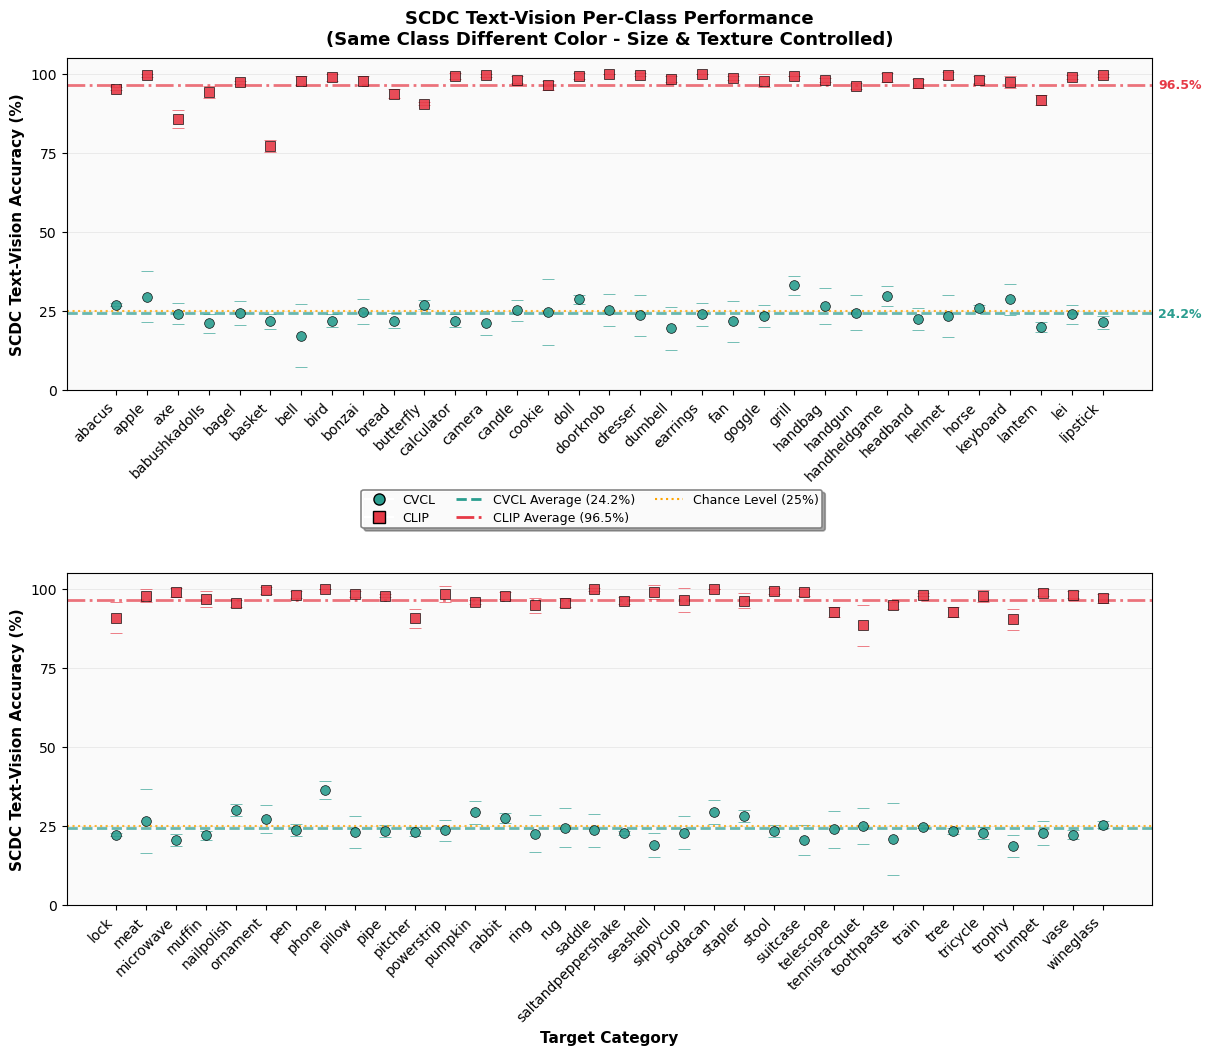


Saved SCDC text-vision plots from CSV data to:
  - C:\Users\jbats\Projects\NTU-Synthetic\PatrickProject\Chart_Generation\Textvision\scdc_textvision_perclass_from_csv.png
  - C:\Users\jbats\Projects\NTU-Synthetic\PatrickProject\Chart_Generation\Textvision\scdc_textvision_perclass_from_csv.pdf


In [3]:
# Create publication-quality visualization with two subplots
fig = plt.figure(figsize=(14, 11))

# Create subplots with space for legend in between
ax1 = plt.subplot2grid((20, 1), (0, 0), rowspan=8)
ax2 = plt.subplot2grid((20, 1), (12, 0), rowspan=8)

# Prepare data for plotting
classes = sorted(list(stats_results[models_to_test[0]].keys()))

# Split classes into two groups
mid_point = len(classes) // 2
classes_first_half = classes[:mid_point]
classes_second_half = classes[mid_point:]

# Define colors and styles
colors = {
    'cvcl-resnext': '#2a9d8f',  # Teal/green color for CVCL
    'clip-res': '#e63946'  # Red color for CLIP
}
markers = {
    'cvcl-resnext': 'o',
    'clip-res': 's'  # Square for CLIP
}
avg_line_styles = {
    'cvcl-resnext': '--',
    'clip-res': '-.'
}

# Short display labels for the legend
short_labels = {
    'cvcl-resnext': 'CVCL',
    'clip-res': 'CLIP'
}

# Store legend elements globally
legend_elements = []

# Function to plot data on an axis
def plot_on_axis(ax, class_subset, is_first=False):
    x_pos = np.arange(len(class_subset))
    
    # Plot each model
    for model_name in models_to_test:
        means = [stats_results[model_name][cls]['mean'] * 100 for cls in class_subset]
        errors = [stats_results[model_name][cls]['ci95'] * 100 for cls in class_subset]
        
        ax.errorbar(x_pos, means, yerr=errors, 
                    label=None,
                    color=colors[model_name],
                    marker=markers[model_name],
                    markersize=7,
                    linewidth=0,
                    capsize=4,
                    capthick=1.5,
                    alpha=0.9,
                    markeredgecolor='black',
                    markeredgewidth=0.5)
    
    # Add chance line
    ax.axhline(y=25, color='#ffa500', linestyle=':', alpha=0.8, linewidth=1.5)
    
    # Calculate and add average lines
    all_classes_means = {}
    for model_name in models_to_test:
        all_means = [stats_results[model_name][cls]['mean'] * 100 for cls in classes]
        all_classes_means[model_name] = np.mean(all_means)
    
    for model_name in models_to_test:
        avg_performance = all_classes_means[model_name]
        ax.axhline(y=avg_performance, 
                  color=colors[model_name], 
                  linestyle=avg_line_styles[model_name], 
                  alpha=0.7, 
                  linewidth=2)
        
        if is_first:
            ax.text(len(class_subset) + 0.8, avg_performance, 
                   f'{avg_performance:.1f}%', 
                   fontsize=9, 
                   color=colors[model_name], 
                   va='center',
                   fontweight='bold')
    
    # Formatting
    ax.set_ylabel('SCDC Text-Vision Accuracy (%)', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(class_subset, rotation=45, ha='right', fontsize=10)
    ax.set_ylim(0, 105)
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.set_facecolor('#fafafa')
    
    # Create legend elements (only once)
    global legend_elements
    if is_first:
        from matplotlib.lines import Line2D
        legend_elements = []
        
        for model_name in models_to_test:
            legend_elements.append(
                Line2D([0], [0], marker=markers[model_name], color='w', 
                      markerfacecolor=colors[model_name], markeredgecolor='black',
                      markersize=8, label=short_labels[model_name])
            )
        
        for model_name in models_to_test:
            avg_val = all_classes_means[model_name]
            legend_elements.append(
                Line2D([0], [0], color=colors[model_name], 
                      linestyle=avg_line_styles[model_name], linewidth=2,
                      label=f'{model_name.upper().split("-")[0]} Average ({avg_val:.1f}%)')
            )
        
        legend_elements.append(
            Line2D([0], [0], color='#ffa500', linestyle=':', linewidth=1.5,
                  label='Chance Level (25%)')
        )

# Plot both halves
plot_on_axis(ax1, classes_first_half, is_first=True)
ax1.set_title('SCDC Text-Vision Per-Class Performance\n(Same Class Different Color - Size & Texture Controlled)', 
              fontsize=13, fontweight='bold', pad=10)

plot_on_axis(ax2, classes_second_half, is_first=False)
ax2.set_xlabel('Target Category', fontsize=11, fontweight='bold')

# --- Legend centered between subplots ---
plt.tight_layout()
plt.subplots_adjust(hspace=0.35)  # spacing between the two axes

legend = fig.legend(
    handles=legend_elements,
    loc='center',
    bbox_to_anchor=(0.5, 0.47),   # centered between plots
    ncol=3,
    fontsize=9,
    frameon=True,
    fancybox=True,
    shadow=True,
    framealpha=0.95,
    borderpad=0.3,
    labelspacing=0.4,
    handlelength=2.2,
    columnspacing=1.6
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_linewidth(1.2)

plt.tight_layout()
plt.subplots_adjust(hspace=0.35)

# Save plots to Textvision folder
png_path = os.path.join(RESULTS_DIR, 'scdc_textvision_perclass_from_csv.png')
pdf_path = os.path.join(RESULTS_DIR, 'scdc_textvision_perclass_from_csv.pdf')

plt.savefig(png_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(pdf_path, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nSaved SCDC text-vision plots from CSV data to:")
print(f"  - {png_path}")
print(f"  - {pdf_path}")

In [ ]:
# Create difference plot (CLIP - CVCL)
if 'cvcl-resnext' in models_to_test and 'clip-res' in models_to_test:
    plt.figure(figsize=(14, 7))
    
    differences = []
    for cls in classes:
        diff = stats_results['clip-res'][cls]['mean'] - stats_results['cvcl-resnext'][cls]['mean']
        differences.append(diff)
    
    # Color based on which model is better
    colors_diff = ['#2ecc71' if d > 0 else '#e74c3c' for d in differences]
    
    bars = plt.bar(range(len(classes)), differences, color=colors_diff, alpha=0.7, 
                   edgecolor='black', linewidth=0.5)
    
    # Add value labels on bars
    for i, (cls, diff) in enumerate(zip(classes, differences)):
        plt.text(i, diff + (0.01 if diff > 0 else -0.02), f'{diff:.2f}',
                ha='center', va='bottom' if diff > 0 else 'top', fontsize=7)
    
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.xlabel('Object Class', fontsize=12, fontweight='bold')
    plt.ylabel('Performance Difference\n(CLIP - CVCL)', fontsize=12, fontweight='bold')
    plt.title('SCDC Text-Vision Model Performance Differences\n(Color Discrimination Within Same Class)',
             fontsize=14, fontweight='bold')
    plt.xticks(range(len(classes)), classes, rotation=45, ha='right', fontsize=9)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', alpha=0.7, label='CLIP Better'),
        Patch(facecolor='#e74c3c', alpha=0.7, label='CVCL Better')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    
    diff_plot_path = os.path.join(RESULTS_DIR, 'scdc_textvision_difference_from_csv.png')
    plt.savefig(diff_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nSaved SCDC difference plot to {diff_plot_path}")
    
    # Print summary statistics
    clip_better = sum(1 for d in differences if d > 0)
    cvcl_better = sum(1 for d in differences if d < 0)
    tied = sum(1 for d in differences if abs(d) < 0.001)
    
    print(f"\n" + "="*60)
    print("SCDC TEXT-VISION PERFORMANCE COMPARISON SUMMARY")
    print("="*60)
    print(f"CLIP performs better: {clip_better}/{len(classes)} classes ({clip_better/len(classes)*100:.1f}%)")
    print(f"CVCL performs better: {cvcl_better}/{len(classes)} classes ({cvcl_better/len(classes)*100:.1f}%)")
    if tied > 0:
        print(f"No significant difference: {tied}/{len(classes)} classes")
    
    avg_diff = np.mean(differences)
    print(f"\nAverage difference (CLIP - CVCL): {avg_diff:.3f} ({avg_diff*100:.1f} percentage points)")
    print(f"Median difference: {np.median(differences):.3f}")
    print(f"Max CLIP advantage: {max(differences):.3f} (class: {classes[differences.index(max(differences))]})")
    print(f"Max CVCL advantage: {min(differences):.3f} (class: {classes[differences.index(min(differences))]})")
else:
    print("Both CVCL and CLIP models needed for difference plot")

In [ ]:
# Create detailed performance table
if len(stats_results) > 0:
    print("\n" + "="*80)
    print("DETAILED SCDC TEXT-VISION PERFORMANCE TABLE")
    print("Task: Color Discrimination Within Same Class")
    print("="*80)
    
    # Create comparison table
    table_data = []
    for cls in classes:
        row = {'Class': cls}
        for model in models_to_test:
            stats = stats_results[model][cls]
            row[f"{model}_mean"] = f"{stats['mean']*100:.1f}%"
            row[f"{model}_ci95"] = f"±{stats['ci95']*100:.1f}%"
        
        # Add difference if both models present
        if 'cvcl-resnext' in models_to_test and 'clip-res' in models_to_test:
            diff = (stats_results['clip-res'][cls]['mean'] - 
                   stats_results['cvcl-resnext'][cls]['mean']) * 100
            row['Difference'] = f"{diff:+.1f}%"
            
            # Mark significant differences
            if abs(diff) > 10:
                row['Significance'] = '***' if diff > 0 else '---'
            elif abs(diff) > 5:
                row['Significance'] = '**' if diff > 0 else '--'
            elif abs(diff) > 2:
                row['Significance'] = '*' if diff > 0 else '-'
            else:
                row['Significance'] = ''
        
        table_data.append(row)
    
    table_df = pd.DataFrame(table_data)
    
    # Display top performers for each model
    print("\nTop 10 Classes for CVCL (Color Discrimination):")
    cvcl_sorted = sorted(classes, key=lambda x: stats_results['cvcl-resnext'][x]['mean'], reverse=True)[:10]
    for i, cls in enumerate(cvcl_sorted, 1):
        acc = stats_results['cvcl-resnext'][cls]['mean'] * 100
        print(f"{i:2d}. {cls:25s}: {acc:.1f}%")
    
    print("\nTop 10 Classes for CLIP (Color Discrimination):")
    clip_sorted = sorted(classes, key=lambda x: stats_results['clip-res'][x]['mean'], reverse=True)[:10]
    for i, cls in enumerate(clip_sorted, 1):
        acc = stats_results['clip-res'][cls]['mean'] * 100
        print(f"{i:2d}. {cls:25s}: {acc:.1f}%")
    
    # Save detailed table to CSV
    table_path = os.path.join(RESULTS_DIR, 'scdc_textvision_detailed_comparison.csv')
    table_df.to_csv(table_path, index=False)
    print(f"\nSaved detailed SCDC comparison table to {table_path}")

In [ ]:
# Statistical comparison
if 'cvcl-resnext' in models_to_test and 'clip-res' in models_to_test:
    from scipy import stats as scipy_stats
    
    print("\n" + "="*60)
    print("STATISTICAL ANALYSIS - SCDC COLOR DISCRIMINATION")
    print("="*60)
    
    # Get all accuracy values
    cvcl_accs = [stats_results['cvcl-resnext'][cls]['mean'] for cls in classes]
    clip_accs = [stats_results['clip-res'][cls]['mean'] for cls in classes]
    
    # Paired t-test (since we're comparing the same classes)
    t_stat, p_value = scipy_stats.ttest_rel(cvcl_accs, clip_accs)
    
    print(f"Paired t-test results:")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.6f}")
    
    if p_value < 0.001:
        print("  Result: Highly significant difference (p < 0.001) ***")
    elif p_value < 0.01:
        print("  Result: Very significant difference (p < 0.01) **")
    elif p_value < 0.05:
        print("  Result: Significant difference (p < 0.05) *")
    else:
        print("  Result: No significant difference")
    
    # Effect size (Cohen's d)
    diff_mean = np.mean(np.array(clip_accs) - np.array(cvcl_accs))
    diff_std = np.std(np.array(clip_accs) - np.array(cvcl_accs))
    cohens_d = diff_mean / diff_std if diff_std > 0 else 0
    
    print(f"\nEffect size (Cohen's d): {cohens_d:.3f}")
    if abs(cohens_d) < 0.2:
        print("  Interpretation: Negligible effect")
    elif abs(cohens_d) < 0.5:
        print("  Interpretation: Small effect")
    elif abs(cohens_d) < 0.8:
        print("  Interpretation: Medium effect")
    else:
        print("  Interpretation: Large effect")
    
    # Overall performance summary
    print(f"\nOverall SCDC Performance (Color Discrimination):")
    print(f"  CVCL: {np.mean(cvcl_accs)*100:.1f}% ± {np.std(cvcl_accs)*100:.1f}%")
    print(f"  CLIP: {np.mean(clip_accs)*100:.1f}% ± {np.std(clip_accs)*100:.1f}%")
    print(f"  Absolute difference: {(np.mean(clip_accs) - np.mean(cvcl_accs))*100:.1f} percentage points")
    print(f"  Relative improvement: {((np.mean(clip_accs) / np.mean(cvcl_accs)) - 1)*100:.1f}%")
    
    print("\nInterpretation:")
    print("- This test measures color discrimination WITHIN the same object class")
    print("- Size and texture are controlled (held constant)")
    print("- Performance reflects pure color-text alignment ability")
    print("- Lower than class discrimination as it's a harder task")

In [ ]:
# Compare SCDC vs Class discrimination if both CSVs exist
class_summary_file = os.path.join(RESULTS_DIR, 'class_textvision_perclass_summary.csv')
if os.path.exists(class_summary_file):
    print("\n" + "="*60)
    print("COMPARISON: CLASS vs SCDC DISCRIMINATION")
    print("="*60)
    
    # Load class discrimination results
    class_df = pd.read_csv(class_summary_file)
    
    # Calculate means for each test type
    for model in models_to_test:
        # Class discrimination mean
        class_means = class_df[class_df['model'] == model]['mean_accuracy'].values
        class_overall = np.mean(class_means) * 100 if len(class_means) > 0 else 0
        
        # SCDC mean
        scdc_means = summary_df[summary_df['model'] == model]['mean_accuracy'].values
        scdc_overall = np.mean(scdc_means) * 100 if len(scdc_means) > 0 else 0
        
        print(f"\n{model}:")
        print(f"  Class discrimination: {class_overall:.1f}%")
        print(f"  SCDC (color within class): {scdc_overall:.1f}%")
        print(f"  Difference: {class_overall - scdc_overall:.1f} percentage points")
        print(f"  Ratio: {class_overall / scdc_overall:.2f}x easier")
    
    print("\nKey Insights:")
    print("- Class discrimination is typically easier (different objects)")
    print("- SCDC is harder (same object, different colors only)")
    print("- The gap reveals how much models rely on object vs color features")
else:
    print("\nClass discrimination results not found for comparison.")
    print(f"Run the class text-vision experiment to generate: {class_summary_file}")